In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import json

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

colors['Fasted'] = colors['FBG']
colors['Random-fed'] = colors['RBG']

In [29]:


lasso = pd.read_csv(r'..\data\interim\fasted_vs_fed_models\LASSO.csv', index_col=0)
rf = pd.read_csv(r'..\data\interim\fasted_vs_fed_models\random_forest.csv', index_col=0)
svr = pd.read_csv(r'..\data\interim\fasted_vs_fed_models\svr.csv', index_col=0)

In [104]:
r

,y,model,Feeding,neg_mean_squared_error_median,r2_median,neg_mean_absolute_percentage_error_median,neg_root_mean_squared_error_median,neg_root_mean_squared_error_mean,neg_mean_absolute_percentage_error_mean,r2_mean,...,neg_root_mean_squared_error_0990,neg_root_mean_squared_error_0991,neg_root_mean_squared_error_0992,neg_root_mean_squared_error_0993,neg_root_mean_squared_error_0994,neg_root_mean_squared_error_0995,neg_root_mean_squared_error_0996,neg_root_mean_squared_error_0997,neg_root_mean_squared_error_0998,neg_root_mean_squared_error_0999
0,ogtt,ols,Fed,3.412391e+07,0.756484,0.135754,5841.564391,5943.636948,0.144104,0.636585,...,4659.836070,6573.206889,5299.377989,5315.699842,6411.417168,3452.688462,7646.250768,8058.565474,3871.398295,7012.432645
1,ogtt,ols,Fasted,5.144212e+07,0.631656,0.168154,7172.315421,7352.169562,0.176254,0.537024,...,8666.976833,6916.727059,5718.269852,10272.929095,7967.187693,13179.586632,8558.311831,6597.852282,11187.044669,6159.096970
2,ogtt,lasso,Fed,4.048543e+07,0.695453,0.145857,6362.816320,6577.032770,0.159265,0.572077,...,5104.337756,8064.986152,6481.590447,6043.037732,7390.958394,5705.554325,8910.750695,10569.768316,4848.155966,7414.556512
3,ogtt,lasso,Fasted,5.785304e+07,0.588444,0.178802,7606.116821,7729.922147,0.189204,0.492115,...,8818.258012,6839.529769,7408.779170,7403.384773,8423.609225,11201.161940,8361.270402,11315.915023,12621.904284,6749.589105
4,ogtt,ridge,Fed,3.412736e+07,0.756469,0.135746,5841.859473,5943.697066,0.144103,0.636572,...,4660.114473,6573.775168,5299.128099,5315.655445,6412.033686,3452.962060,7646.562519,8059.007583,3871.975516,7011.989181
5,ogtt,ridge,Fasted,5.154653e+07,0.633363,0.167394,7179.591306,7344.789148,0.176131,0.537397,...,8710.763984,6606.830207,5626.483070,11533.816786,7967.997199,13526.314046,8558.361624,6596.675592,11187.337821,5879.278590
6,ogtt,svm,Fed,3.412396e+07,0.756486,0.135753,5841.568466,5943.510314,0.144098,0.636591,...,4659.827189,6573.203953,5299.347069,5315.691701,6411.437797,3452.684068,7646.267462,8058.603002,3871.424727,7012.388151
7,ogtt,svm,Fasted,5.154757e+07,0.633385,0.167391,7179.663765,7344.670457,0.176128,0.537404,...,8710.907662,6606.409201,5626.781684,11534.189224,7967.196560,13526.949294,8558.310666,6596.481633,11187.043557,5879.006986
8,ogtt,pls,Fed,4.495012e+07,0.679184,0.157703,6704.483938,6794.948600,0.164465,0.526279,...,4234.416338,7831.576029,5388.973128,5529.082301,8570.170247,3220.003269,9069.276253,9252.397483,5772.780937,8389.896187
9,ogtt,pls,Fasted,4.985804e+07,0.649602,0.159438,7061.022232,7275.078906,0.168281,0.534227,...,8920.909294,6942.894667,4735.633015,10205.653393,9252.422630,11366.221592,7782.703897,5559.203522,11813.739721,7186.879474


In [117]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', 
                index_col=0).rename({'x': 'Feeding'}, axis=1)

melt = r.melt(value_vars=r.filter(regex='neg_mean_squared_error_\d').columns, id_vars=['model', 'Feeding', 'y']) \
        .drop('variable', axis=1)
melt['model2'] = melt['model'].map({'ols': 'OLS', 'lasso': 'LASSO (L1)', 'ridge': 'Ridge (L2)', 
                                   'svm': 'SVM\n(Linear kernel)', 'pls': 'PLS', 'rf': 'Random\nForest',
                                   'xgboost': 'XGBoost'})
ogtt = melt.loc[melt['y'] == 'ogtt'].drop('y', axis=1)
insulin = melt.loc[melt['y'] == 'insulin'].drop('y', axis=1)
weight = melt.loc[melt['y'] == 'weight'].drop('y', axis=1)

In [115]:
ogtt

,model,Feeding,value,model2
0,ols,Fed,4.168725e+07,OLS
1,ols,Fasted,5.138281e+07,OLS
2,lasso,Fed,4.369901e+07,LASSO (L1)
3,lasso,Fasted,4.280327e+07,LASSO (L1)
4,ridge,Fed,4.168743e+07,Ridge (L2)
...,...,...,...,...
35971,svm,Fasted,3.456272e+07,SVM\n(Linear kernel)
35972,pls,Fed,7.039036e+07,PLS
35973,pls,Fasted,5.165124e+07,PLS
35974,rf,Fed,5.998337e+07,Random\nForest


In [124]:
r

,y,model,Feeding,neg_mean_squared_error_median,r2_median,neg_mean_absolute_percentage_error_median,neg_root_mean_squared_error_median,neg_root_mean_squared_error_mean,neg_mean_absolute_percentage_error_mean,r2_mean,...,neg_root_mean_squared_error_0990,neg_root_mean_squared_error_0991,neg_root_mean_squared_error_0992,neg_root_mean_squared_error_0993,neg_root_mean_squared_error_0994,neg_root_mean_squared_error_0995,neg_root_mean_squared_error_0996,neg_root_mean_squared_error_0997,neg_root_mean_squared_error_0998,neg_root_mean_squared_error_0999
0,ogtt,ols,Fed,3.412391e+07,0.756484,0.135754,5841.564391,5943.636948,0.144104,0.636585,...,4659.836070,6573.206889,5299.377989,5315.699842,6411.417168,3452.688462,7646.250768,8058.565474,3871.398295,7012.432645
1,ogtt,ols,Fasted,5.144212e+07,0.631656,0.168154,7172.315421,7352.169562,0.176254,0.537024,...,8666.976833,6916.727059,5718.269852,10272.929095,7967.187693,13179.586632,8558.311831,6597.852282,11187.044669,6159.096970
2,ogtt,lasso,Fed,4.048543e+07,0.695453,0.145857,6362.816320,6577.032770,0.159265,0.572077,...,5104.337756,8064.986152,6481.590447,6043.037732,7390.958394,5705.554325,8910.750695,10569.768316,4848.155966,7414.556512
3,ogtt,lasso,Fasted,5.785304e+07,0.588444,0.178802,7606.116821,7729.922147,0.189204,0.492115,...,8818.258012,6839.529769,7408.779170,7403.384773,8423.609225,11201.161940,8361.270402,11315.915023,12621.904284,6749.589105
4,ogtt,ridge,Fed,3.412736e+07,0.756469,0.135746,5841.859473,5943.697066,0.144103,0.636572,...,4660.114473,6573.775168,5299.128099,5315.655445,6412.033686,3452.962060,7646.562519,8059.007583,3871.975516,7011.989181
5,ogtt,ridge,Fasted,5.154653e+07,0.633363,0.167394,7179.591306,7344.789148,0.176131,0.537397,...,8710.763984,6606.830207,5626.483070,11533.816786,7967.997199,13526.314046,8558.361624,6596.675592,11187.337821,5879.278590
6,ogtt,svm,Fed,3.412396e+07,0.756486,0.135753,5841.568466,5943.510314,0.144098,0.636591,...,4659.827189,6573.203953,5299.347069,5315.691701,6411.437797,3452.684068,7646.267462,8058.603002,3871.424727,7012.388151
7,ogtt,svm,Fasted,5.154757e+07,0.633385,0.167391,7179.663765,7344.670457,0.176128,0.537404,...,8710.907662,6606.409201,5626.781684,11534.189224,7967.196560,13526.949294,8558.310666,6596.481633,11187.043557,5879.006986
8,ogtt,pls,Fed,4.495012e+07,0.679184,0.157703,6704.483938,6794.948600,0.164465,0.526279,...,4234.416338,7831.576029,5388.973128,5529.082301,8570.170247,3220.003269,9069.276253,9252.397483,5772.780937,8389.896187
9,ogtt,pls,Fasted,4.985804e+07,0.649602,0.159438,7061.022232,7275.078906,0.168281,0.534227,...,8920.909294,6942.894667,4735.633015,10205.653393,9252.422630,11366.221592,7782.703897,5559.203522,11813.739721,7186.879474


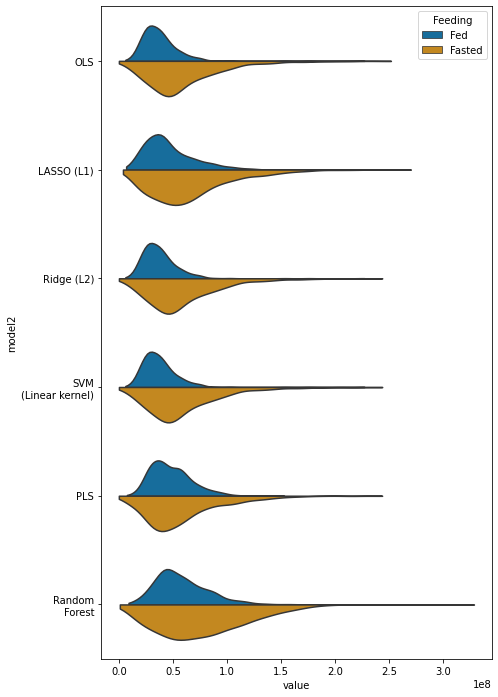

In [125]:
ogtt

,model,Feeding,value,model2
0,ols,Fed,4.168725e+07,OLS
1,ols,Fasted,5.138281e+07,OLS
2,lasso,Fed,4.369901e+07,LASSO (L1)
3,lasso,Fasted,4.280327e+07,LASSO (L1)
4,ridge,Fed,4.168743e+07,Ridge (L2)
...,...,...,...,...
35971,svm,Fasted,3.456272e+07,SVM\n(Linear kernel)
35972,pls,Fed,7.039036e+07,PLS
35973,pls,Fasted,5.165124e+07,PLS
35974,rf,Fed,5.998337e+07,Random\nForest


In [127]:
r.loc[(r['model'] == model) & (r['Feeding'] == 'Fasted') & (r['y'] == 'ogtt'), 
                     'neg_mean_squared_error_median'].iloc[0]

71818797.47641927

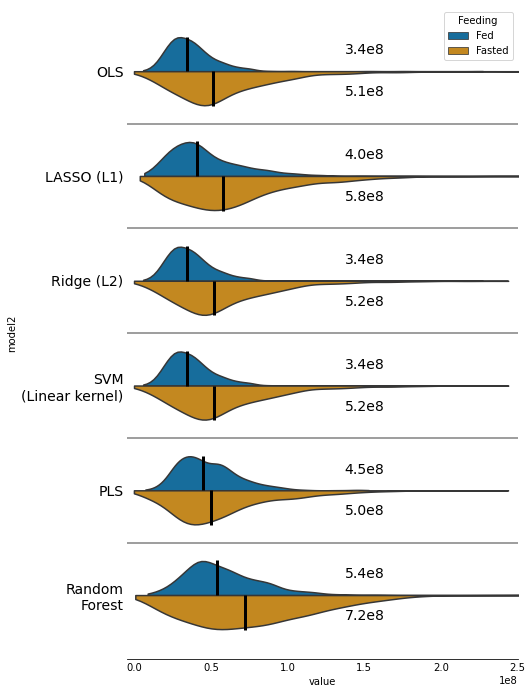

In [131]:
colors['Fed'] = colors['RBG']
colors['Fasted'] = colors['FBG']

fig, ax = plt.subplots(figsize=(7, 12))

vp = sns.violinplot(
    data=ogtt, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

for i, model in enumerate(r['model'].unique()):
    fbg_mean = r.loc[(r['model'] == model) & (r['Feeding'] == 'Fasted') & (r['y'] == 'ogtt'), 
                     'neg_mean_squared_error_median'].iloc[0]
    rbg_mean = r.loc[(r['model'] == model) & (r['Feeding'] == 'Fed') & (r['y'] == 'ogtt'),    
                     'neg_mean_squared_error_median'].iloc[0]
    plt.plot([fbg_mean, fbg_mean], [i, i + 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.plot([rbg_mean, rbg_mean], [i, i - 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.annotate(str(round(fbg_mean/1e7, 1)) + 'e8', xy=(1.5e8, i + 0.2), ha='center', va='center', fontsize=14)
    plt.annotate(str(round(rbg_mean/1e7, 1)) + 'e8', xy=(1.5e8, i - 0.2), ha='center', va='center', fontsize=14)
    
plt.xlim(-5e6, 2.5e8)
plt.yticks(fontsize=14)

# print(plt.yticks()[1][0].get_text())
for y in np.arange(0.5, 5, 1):
    plt.axhline(y=y, color='gray')

plt.tick_params(axis='both', length=0)
# plt.grid(axis='x', visible=None, ) 
# ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
# plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
sns.despine(left=True)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)

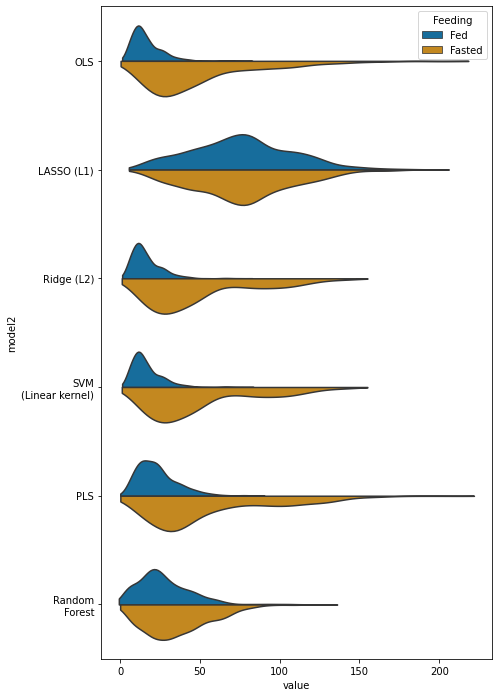

In [130]:
fig, ax = plt.subplots(figsize=(7, 12))
vp = sns.violinplot(
    data=weight, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

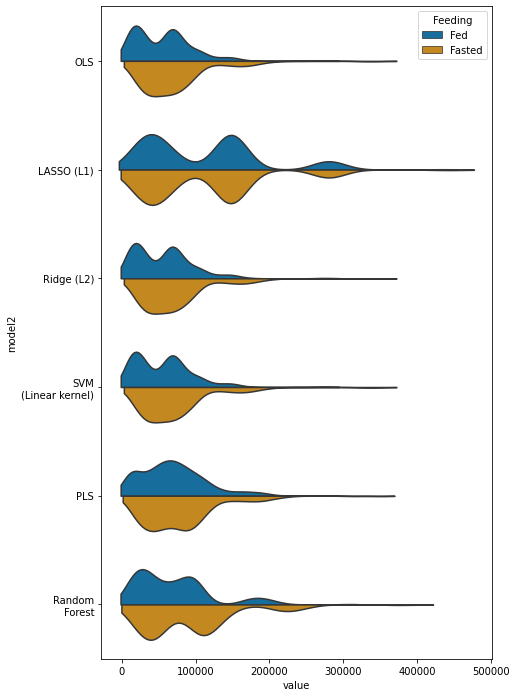

In [129]:
fig, ax = plt.subplots(figsize=(7, 12))
vp = sns.violinplot(
    data=insulin, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

In [7]:
lasso['model'] = 'lasso'
rf['model'] = 'rf'
svr['model'] = 'model'
concat = pd.concat([lasso, rf, svr])
concat['Feeding'] = concat['variable'].map({'FBG': 'Fasted', 'RBG': 'Random-fed'})
concat

,variable,value,dummy,model,Feeding
0,FBG,0.376486,dummy,lasso,Fasted
1,FBG,0.194368,dummy,lasso,Fasted
2,FBG,0.286964,dummy,lasso,Fasted
3,FBG,0.366897,dummy,lasso,Fasted
4,FBG,0.168847,dummy,lasso,Fasted
...,...,...,...,...,...
595,RBG,0.161203,dummy,model,Random-fed
596,RBG,0.153347,dummy,model,Random-fed
597,RBG,0.122726,dummy,model,Random-fed
598,RBG,0.461233,dummy,model,Random-fed


In [98]:
d = {}
for df, name in zip([lasso, rf, svr], ['lasso', 'rf', 'svr']):
    d[name] = {}
    d[name]['rbg_mean'] = df.loc[df['variable'] == 'RBG', 'value'].mean()
    d[name]['fbg_mean'] = df.loc[df['variable'] == 'FBG', 'value'].mean()

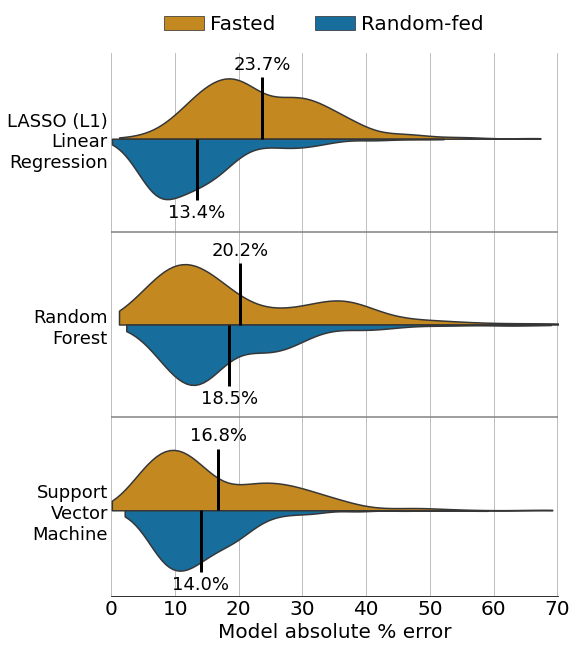

In [111]:
fig, ax = plt.subplots(figsize=(8, 10))

vp = sns.violinplot(
    data=concat, x='value', y='model',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

for i, model in enumerate(['lasso', 'rf', 'svr']):
    fbg_mean = d[model]['fbg_mean']
    rbg_mean = d[model]['rbg_mean']
    plt.plot([fbg_mean, fbg_mean], [i, i - 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.plot([rbg_mean, rbg_mean], [i, i + 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.annotate(str(round(fbg_mean*100, 1)) + '%', xy=(fbg_mean, i - 0.4), ha='center', va='center', fontsize=18)
    plt.annotate(str(round(rbg_mean*100, 1)) + '%', xy=(rbg_mean, i + 0.4), ha='center', va='center', fontsize=18)
plt.axhline(y=0.5, color='gray')
plt.axhline(y=1.5, color='gray')
plt.xlim(0, 0.701)
plt.xticks(ticks=plt.xticks()[0][:-1], labels=[str(x) for x in range(0, 80, 10)], fontsize=20)
plt.xlabel('Model absolute % error', fontsize=20)
# plt.ylabel('Model', fontsize=18)
plt.ylabel(None)
plt.yticks(ticks=[0,1,2], 
           labels=['LASSO (L1)\nLinear\nRegression', 'Random\nForest', 'Support\nVector\nMachine'],
           fontsize=18, ha='right')
plt.tick_params(axis='both', length=0)
plt.grid(axis='x', visible=None, ) 
ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
sns.despine(left=True, bottom=False)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
vp = sns.violinplot(
data=errors, x='value', y='dummy',
orient='h', split=True, hue='variable',
scale='width', cut=0.4,
palette=colors, 
inner=None, 
ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)
